In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer

from time import time
import pickle


In [3]:
df = pd.read_csv("Bangla_Corpus.csv")
df.head()


,Unnamed: 0,text,label,target
0,0,অবিশ^াস্য কিন্তু সত্য। প্রাচীনকালে হিন্দু মালা...,Hateful,1
1,1,"আজ বিশ^ হাড়কিপটা দিবস, উইশ করুন আপনার সেই কিপ্...",Neutral,0
2,2,চীনকে চিনে নিতে ৭২ ঘন্টা সময় চায় ভারত।,Hateful,1
3,3,"আমারে নিবা মাঝি লগে? ব্রীজ হইছে, ব্রীজ দিয়া যা।",Neutral,0
4,4,বাম আর নাস্তিক আজ আওয়ামীলীগের পিঠে সওয়ার হয়েছে।,Hateful,1


In [4]:
def map_labels(df):
    mapping_dict = {
        'Hateful': 1,
        'Neutral': 0,
        'Like': 0,  # change if needed
    }
    df['label'] = df['label'].map(mapping_dict).fillna(df['label']).astype(int)
    return df

df = map_labels(df)
print("Unique labels in dataset:", df['label'].unique())


Unique labels in dataset: [1 0]


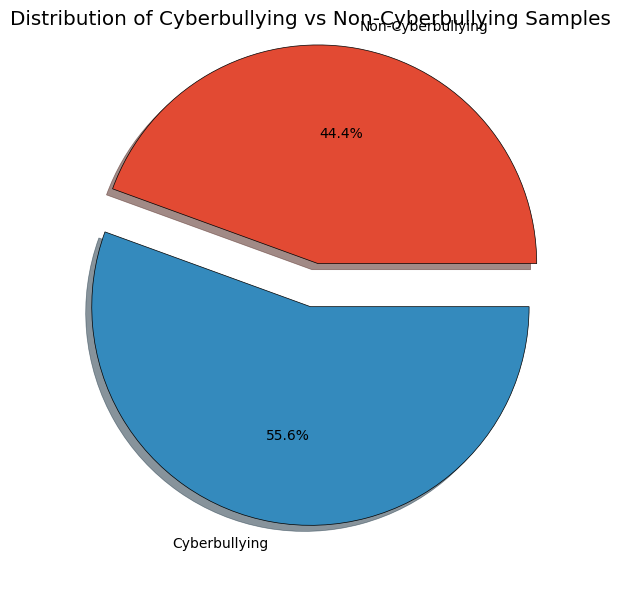

In [5]:
def performdatadistribution(df):
    total = df.shape[0]
    num_non_cyber = df[df['label']==0].shape[0]
    
    slices = [num_non_cyber/total, (total-num_non_cyber)/total]
    labeling = ['Non-Cyberbullying', 'Cyberbullying']
    explode = [0.2, 0]
    
    plt.figure(figsize=(6,6))
    plt.pie(slices, explode=explode, shadow=True, autopct="%1.1f%%", labels=labeling, wedgeprops={'edgecolor': 'black'})
    plt.title('Distribution of Cyberbullying vs Non-Cyberbullying Samples')
    plt.tight_layout()
    plt.show()

performdatadistribution(df)


In [6]:
def clean_bangla_text(text):
    text = str(text)
    text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # keep Bangla Unicode characters and space only
    text = re.sub(r'\s+', ' ', text).strip()        # normalize whitespace
    return text

df['cleaned'] = df['text'].apply(clean_bangla_text)
df['length_cleaned'] = df['cleaned'].str.len()
df.head()


,Unnamed: 0,text,label,target,cleaned,length_cleaned
0,0,অবিশ^াস্য কিন্তু সত্য। প্রাচীনকালে হিন্দু মালা...,1,1,অবিশাস্য কিন্তু সত্য প্রাচীনকালে হিন্দু মালাউন...,59
1,1,"আজ বিশ^ হাড়কিপটা দিবস, উইশ করুন আপনার সেই কিপ্...",0,0,আজ বিশ হাড়কিপটা দিবস উইশ করুন আপনার সেই কিপ্টা...,54
2,2,চীনকে চিনে নিতে ৭২ ঘন্টা সময় চায় ভারত।,1,1,চীনকে চিনে নিতে ৭২ ঘন্টা সময় চায় ভারত,37
3,3,"আমারে নিবা মাঝি লগে? ব্রীজ হইছে, ব্রীজ দিয়া যা।",0,0,আমারে নিবা মাঝি লগে ব্রীজ হইছে ব্রীজ দিয়া যা,44
4,4,বাম আর নাস্তিক আজ আওয়ামীলীগের পিঠে সওয়ার হয়েছে।,1,1,বাম আর নাস্তিক আজ আওয়ামীলীগের পিঠে সওয়ার হয়েছে,46


In [7]:
def performdatasplit(test_size, random_state, df):
    X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['label'], test_size=test_size, random_state=random_state)
    print(f"Total samples: {df.shape[0]}")
    print(f"Train samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")

    # Load stopwords from CSV file
    try:
        stopwords_df = pd.read_csv('bangla_stopwords.csv', header=None, encoding='utf-8')
        stopwords_list = stopwords_df[0].tolist()
        print(f"Loaded {len(stopwords_list)} stopwords.")
    except Exception as e:
        print(f"Could not load stopwords file: {e}")
        stopwords_list = None

    tfidfvector = TfidfVectorizer(stop_words=stopwords_list, lowercase=True)
    X_train_tfidf = tfidfvector.fit_transform(X_train.values.astype('U'))
    X_test_tfidf = tfidfvector.transform(X_test.values.astype('U'))

    # Save fitted TF-IDF vectorizer object for later use
    pickle.dump(tfidfvector, open("tfidfvector.pkl", "wb"))

    return X_train, X_test, y_train, y_test, X_train_tfidf, X_test_tfidf, tfidfvector, stopwords_list

X_train, X_test, y_train, y_test, X_train_tfidf, X_test_tfidf, tfidfvector, stopwords_list = performdatasplit(0.2, 42, df)


Total samples: 4500
Train samples: 3600
Test samples: 900
Loaded 112 stopwords.


C:\Users\samis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অথব', 'অন', 'অবশ', 'আগ', 'আছ', 'আদ', 'আপন', 'আব', 'আম', 'আমর', 'আস', 'উন', 'এইজন', 'একট', 'এট', 'এব', 'ওয', 'ওয়', 'কর', 'করছ', 'করত', 'করল', 'জন', 'তব', 'পর', 'বল', 'যদ', 'রক', 'রণ', 'রত', 'হইব', 'হত', 'হব', 'হয', 'হয়ত'] not in stop_words.
  warnings.warn(


In [8]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier

def pipeline(X_train, y_train, X_test, y_test):
    MODELS = [
        LinearSVC(max_iter=10000),
        LogisticRegression(max_iter=1000),
        MultinomialNB(),
        DecisionTreeClassifier(),
        AdaBoostClassifier(),
        BaggingClassifier(),
        SGDClassifier(max_iter=1000)
    ]

    results = []
    for model in MODELS:
        metrics = {}
        metrics['Algorithm'] = model.__class__.__name__
        print(f"Training {metrics['Algorithm']}...")

        start = time()
        model.fit(X_train, y_train)
        metrics['Training Time'] = time() - start

        # Save trained model
        pickle.dump(model, open(metrics['Algorithm']+".pkl", "wb"))

        start = time()
        y_pred = model.predict(X_test)
        metrics['Prediction Time'] = time() - start

        metrics['Accuracy : Test'] = accuracy_score(y_test, y_pred)
        metrics['F1 Score : Test'] = f1_score(y_test, y_pred)
        metrics['Precision : Test'] = precision_score(y_test, y_pred)
        metrics['Recall : Test'] = recall_score(y_test, y_pred)

        print(f"{metrics['Algorithm']} Done: Accuracy={metrics['Accuracy : Test']:.3f}, F1={metrics['F1 Score : Test']:.3f}")
        results.append(metrics)
    return results

final_results = pipeline(X_train_tfidf, y_train, X_test_tfidf, y_test)


Training LinearSVC...
LinearSVC Done: Accuracy=0.710, F1=0.744
Training LogisticRegression...
LogisticRegression Done: Accuracy=0.701, F1=0.742
Training MultinomialNB...
MultinomialNB Done: Accuracy=0.717, F1=0.754
Training DecisionTreeClassifier...
DecisionTreeClassifier Done: Accuracy=0.618, F1=0.655
Training AdaBoostClassifier...
AdaBoostClassifier Done: Accuracy=0.620, F1=0.702
Training BaggingClassifier...
BaggingClassifier Done: Accuracy=0.652, F1=0.669
Training SGDClassifier...
SGDClassifier Done: Accuracy=0.707, F1=0.739


In [9]:
results_df = pd.DataFrame(final_results)
results_df = results_df.sort_values(by='F1 Score : Test', ascending=False).reset_index(drop=True)
results_df


,Algorithm,Training Time,Prediction Time,Accuracy : Test,F1 Score : Test,Precision : Test,Recall : Test
0,MultinomialNB,0.001584,0.000000,0.716667,0.753623,0.745698,0.761719
1,LinearSVC,0.007676,0.001649,0.710000,0.743867,0.747535,0.740234
2,LogisticRegression,0.006107,0.000000,0.701111,0.742090,0.728814,0.755859
3,SGDClassifier,0.006094,0.000000,0.706667,0.739130,0.748000,0.730469
4,AdaBoostClassifier,0.172376,0.008096,0.620000,0.702091,0.633648,0.787109
5,BaggingClassifier,1.223721,0.004215,0.652222,0.668783,0.729792,0.617188
6,DecisionTreeClassifier,0.172281,0.001526,0.617778,0.654618,0.673554,0.636719


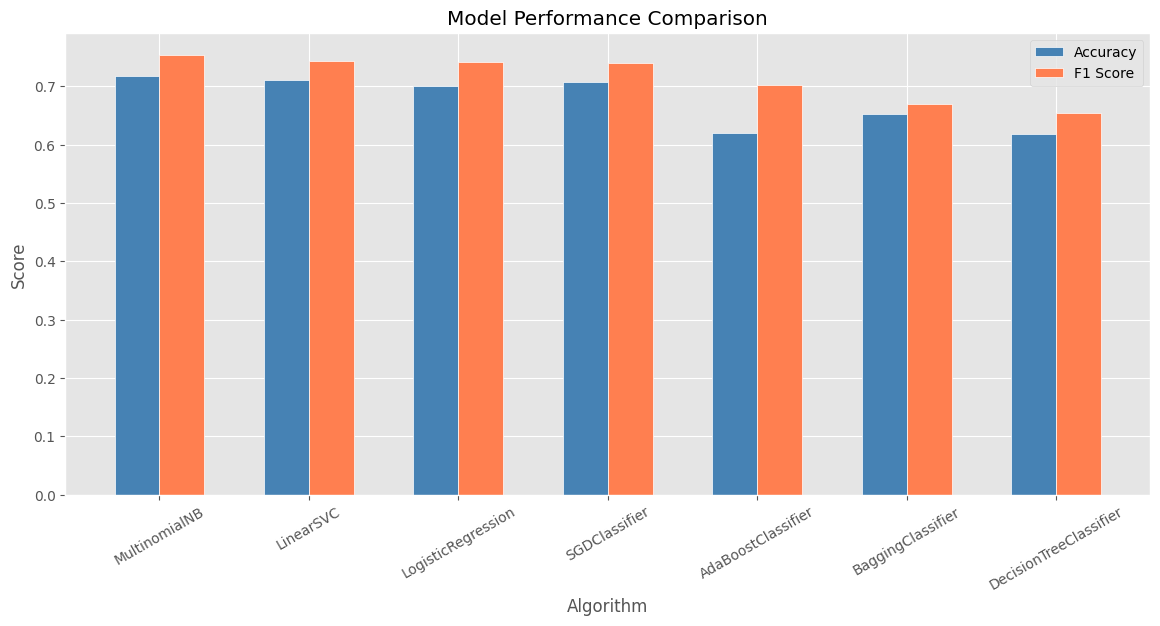

In [10]:
import numpy as np

plt.figure(figsize=(14,6))
barWidth = 0.3
r1 = np.arange(len(results_df))
r2 = [x + barWidth for x in r1]

plt.bar(r1, results_df['Accuracy : Test'], width=barWidth, color='steelblue', edgecolor='white', label='Accuracy')
plt.bar(r2, results_df['F1 Score : Test'], width=barWidth, color='coral', edgecolor='white', label='F1 Score')

plt.xlabel('Algorithm')
plt.ylabel('Score')
plt.xticks([r + barWidth/2 for r in range(len(results_df))], results_df['Algorithm'], rotation=30)
plt.legend()
plt.title('Model Performance Comparison')
plt.show()


In [11]:
new_texts = ["তুই কই এখন"]

# Load fitted TF-IDF vectorizer
tfidf_vectorizer = pickle.load(open("tfidfvector.pkl", "rb"))

# Transform new texts
X_new_tfidf = tfidf_vectorizer.transform(new_texts)

# Load a trained model, e.g., LinearSVC
model = pickle.load(open("LinearSVC.pkl", "rb"))

predictions = model.predict(X_new_tfidf)

for text, pred in zip(new_texts, predictions):
    label = "Cyberbullying" if pred == 1 else "Non-Cyberbullying"
    print(f"Text: {text}")
    print(f"Prediction: {label}\n")


Text: তুই কই এখন
Prediction: Non-Cyberbullying



C:\Users\samis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['অথব', 'অন', 'অবশ', 'আগ', 'আছ', 'আদ', 'আপন', 'আব', 'আম', 'আমর', 'আস', 'উন', 'এইজন', 'একট', 'এট', 'এব', 'ওয', 'ওয়', 'কর', 'করছ', 'করত', 'করল', 'জন', 'তব', 'পর', 'বল', 'যদ', 'রক', 'রণ', 'রত', 'হইব', 'হত', 'হব', 'হয', 'হয়ত'] not in stop_words.
  warnings.warn(


In [12]:
from sklearn.model_selection import GridSearchCV

def tune_model(clf, param_grid, X_train, y_train, X_test, y_test):
    scorer = make_scorer(f1_score)
    grid = GridSearchCV(clf, param_grid, scoring=scorer, cv=5)
    grid.fit(X_train, y_train)

    best_clf = grid.best_estimator_
    y_pred = best_clf.predict(X_test)

    print(f"Best parameters: {grid.best_params_}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(f"Test F1 Score: {f1_score(y_test, y_pred):.3f}")
    print(f"Test Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"Test Recall: {recall_score(y_test, y_pred):.3f}")

    pickle.dump(best_clf, open("LinearSVC_Tuned.pkl", "wb"))

param_grid = {'C': [0.25, 0.5, 0.75, 1, 1.2]}
clf = LinearSVC(max_iter=10000)

tune_model(clf, param_grid, X_train_tfidf, y_train, X_test_tfidf, y_test)


Best parameters: {'C': 0.25}
Test Accuracy: 0.702
Test F1 Score: 0.739
Test Precision: 0.736
Test Recall: 0.742
